In [2]:
!nvidia-smi

Sat Jul 29 09:22:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
#@title Package Installation
!pip3 install pytorch-lightning ydata-profiling swifter pycaret[full] transformers[torch] datasets Pillow

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
#@title Setup
import os
from pathlib import Path

data_path = Path('/content/drive/My Drive/pcml_data/6USML')
model_path = Path('/content/drive/My Drive/pcml_data/6USML/models')
cache_path = Path('/content/drive/My Drive/pcml_data/6USML/cache')

# Set cache for Huggingface Transformers
os.environ['HF_HOME'] = str(cache_path / 'huggingface')

There are 2 datasets and 4 tasks that you need to do for this assessment.

The 2 datasets are:
1. SMS Spam detection
2. Facial emotion detection

For each of the use-case, please perform:
1. Knowledge representation using Unsupervised Machine Learning
2. Representation Learning using Deep Neural Networks

This is a heavily guided assessment with most of the heavy lifting done in the form of templated codes.

### Functions that will help you
Load these functions as and when you require

In [6]:
import nltk
import torch
import pandas as pd
import numpy as np
import swifter
import pytorch_lightning as pl
from pandas_profiling import ProfileReport
from sklearn.metrics import classification_report
from string import punctuation
from typing import Any, Dict, List, Optional
from torchmetrics.classification import Accuracy, F1Score
from torch import nn, optim
from torch.utils.data import random_split, DataLoader
from torchvision import datasets, models, transforms
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from torch.utils.data import DataLoader
from datasets import Dataset, load_dataset, DatasetDict
from transformers import AutoTokenizer, PreTrainedTokenizerBase, AutoModelForSequenceClassification

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

<ipython-input-6-b13a1314c88f>:7: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
# This is used to clean sentences up for traditional NLP techniques
# ## Removes stopwords, remove punctuations, lowercase, lemmatize
sw = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def clean_text(s):
    # Convert text to lowercase
    s = s.lower()

    # Remove stopwords
    # some nltk stopwords will not match words tokenized by nltk
    tokens = [t.strip() for t in s.split(' ') if t not in sw]

    # Tokenize the text again using nltk
    s = ' '.join(tokens)
    tokens = word_tokenize(s)

    # Remove tokens that start with @
    tokens = [t for t in tokens if not t.startswith('@')]

    # Remove punctuations
    to_remove = list(punctuation) + ["``", "''"]
    tokens = [token for token in tokens if token not in to_remove]

    # Convert tokens into their stemmed form
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    return ' '.join(tokens)

In [8]:
# This is used to score labels using a zero-shot classifier
# ## You have to supply the text, model, and candidate labels
def predict_label(text, classifier, candidate_labels):
    results = classifier(text, candidate_labels)
    return results['labels'][0]

In [9]:
# This is the datamodule used to load images in PyTorch Lightning
class ImageDataModule(pl.LightningDataModule):
    def __init__(self, dataset):
        super().__init__()
        self.train_test_split = 0.7
        self.length = len(dataset)
        self.train_size = int(self.length * self.train_test_split)
        self.val_size = self.length - self.train_size
        self.setup()

    def setup(self, stage=None):
        # This section is use to do any processing of the downloaded dataset
        self.train_data, self.val_data = random_split(dataset, [self.train_size, self.val_size])

    def train_dataloader(self):
        # Assign to train dataloader
        return DataLoader(self.train_data, batch_size=32)

    def val_dataloader(self):
        # Assign to validation dataloader
        return DataLoader(self.val_data, batch_size=32)

In [10]:
# This is the cnn model in PyTorch Lightning
# ## You will need to supply model, loss function, metric, and number of classes
class ImageClassifier(pl.LightningModule):
    def __init__(self, model, loss, metric, num_classes):
        # Step 1: Define the model architecture here.
        super().__init__()
        self.model = model

        # Step 3: Define Loss Function here
        self.loss = loss

        # Define metric here
        self.metric = metric

    def configure_optimizers(self):
        # Step 2: choose your optimizer.
        return torch.optim.AdamW(self.parameters(), lr=1e-3)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_no):
        # Step 4: Define training step here
        x, y = batch
        logits = self.model(x)

        loss = self.loss(logits, y)

        acc = self.metric(logits, y.to('cuda'))
        self.log('train_loss', loss)
        self.log("train_metric", acc, on_step=False, on_epoch=True)
        return {'loss': loss, 'train_metric': acc}

    def validation_step(self, batch, batch_no):
        # Step 5: Define validation step here
        x, y = batch
        logits = self.model(x)
        loss = self.loss(logits, y)

        acc = self.metric(logits, y.to('cuda'))
        self.log('validation_loss', loss)
        self.log("validation_metric", acc, on_step=False, on_epoch=True)
        return {'loss': loss, 'val_metric': acc}

    def test_step(self, batch, batch_no):
        x, y = batch
        logits = self.model(x)
        loss = self.loss(logits, y)

        acc = self.accuracy(logits, y.to('cuda'))
        self.log('test_loss', loss)
        self.log("test_accuracy", acc, on_step=False, on_epoch=True)
        return {'loss': loss, 'test_accuracy': acc}

    def predict_step(self, batch):
        # Step 6: If we want to use it to predict
        x, y = batch
        return self.model(x)

### Assessment #1 Spam or Ham?
Predict if each sms is a spam or not spam (ham).

In [16]:
# Load the data
spam_data = pd.read_csv(data_path / 'spam.csv')
spam_data

,label,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [27]:
# Do we have imbalanced data problem?
spam_data.profile_report(minimal=True)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In this section, you will apply traditional ML techniques in NLP

In [17]:
# Step 1: Do you need to do any text processing?
spam_data['sms'] = spam_data.sms.swifter.apply(lambda x: clean_text(x))

Pandas Apply:   0%|          | 0/5572 [00:00<?, ?it/s]

In [18]:
# Step 2: How do you represent texts into something that can be processed
# mathematically by a model?

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.decomposition import NMF

# Call an instance of tfidf
tfidf = TfidfVectorizer()
csr_mat = tfidf.fit_transform(spam_data['sms'])

# Normalize the sparse matrix
csr_mat_norm = normalize(csr_mat)

In [30]:
# Step 3: Apply an unsupervised model to learn knowledge representations of language
# Create a NMF instance and fit the model
nmf = NMF(n_components=10, random_state=42, max_iter=500)
nmf_features = nmf.fit_transform(csr_mat_norm)

In [32]:
# Step 4: Combined the learned features with the original texts and label
nmf_features = pd.DataFrame(nmf_features)
spam_nmf = pd.concat([spam_data, nmf_features], axis=1)
spam_nmf

,label,sms,0,1,2,3,4,5,6,7,8,9
0,ham,go jurong point crazy .. available bugis n gre...,0.000000,0.000000,0.015060,0.000916,0.001451,0.063437,0.001197,0.000000,0.001212,0.000000
1,ham,ok lar ... joking wif u oni ...,0.000095,0.112746,0.000000,0.000000,0.000000,0.024936,0.000000,0.000000,0.000000,0.000000
2,spam,free entry 2 wkly comp win fa cup final tkts 2...,0.000000,0.000000,0.000000,0.000000,0.008739,0.000000,0.068817,0.000000,0.000000,0.000000
3,ham,u dun say early hor ... u c already say ...,0.000071,0.000222,0.008790,0.005326,0.000000,0.047157,0.000000,0.000000,0.002204,0.003155
4,ham,nah think go usf life around though,0.000434,0.000000,0.026479,0.005233,0.000000,0.035465,0.011565,0.000129,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
5567,spam,2nd time tried 2 contact u. u å£750 pound priz...,0.000000,0.000000,0.000000,0.004317,0.126422,0.000874,0.000142,0.022486,0.000000,0.000000
5568,ham,ì_ b going esplanade fr home,0.000000,0.000000,0.000000,0.000000,0.000000,0.060156,0.000000,0.006102,0.000000,0.168256
5569,ham,pity mood that so ... any suggestion,0.000233,0.000657,0.012255,0.000616,0.000000,0.000000,0.000064,0.000070,0.000000,0.000000
5570,ham,guy bitching acted like i 'd interested buying...,0.000000,0.000000,0.013289,0.005650,0.003348,0.006518,0.050356,0.000000,0.000000,0.000000


In [38]:
# Step 5: Prepare for classification
from pycaret.classification import ClassificationExperiment

clf = ClassificationExperiment()

clf.setup(
    data=spam_nmf,
    target='label',
    ignore_features=['sms'],
    fix_imbalance=True,
)

,Description,Value
0,Session id,2344
1,Target,label
2,Target type,Binary
3,Target mapping,"ham: 0, spam: 1"
4,Original data shape,"(5572, 12)"
5,Transformed data shape,"(8426, 11)"
6,Transformed train set shape,"(6754, 11)"
7,Transformed test set shape,"(1672, 11)"
8,Ignore features,1
9,Numeric features,10


In [34]:
# Step 6: Check model performances, which model performs best?
best_model = clf.compare_models(sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9572,0.9756,0.8736,0.8213,0.8448,0.8201,0.8218,6.5540
lightgbm,Light Gradient Boosting Machine,0.9587,0.9753,0.8735,0.8305,0.8496,0.8257,0.8273,0.4560
et,Extra Trees Classifier,0.9605,0.9747,0.8505,0.8581,0.8515,0.8288,0.8306,0.9430
rf,Random Forest Classifier,0.9615,0.9735,0.8602,0.8560,0.8563,0.8341,0.8353,1.7910
gbc,Gradient Boosting Classifier,0.9431,0.9733,0.8832,0.7427,0.8060,0.7730,0.7775,1.6180
xgboost,Extreme Gradient Boosting,0.9628,0.9722,0.8716,0.8557,0.8620,0.8405,0.8416,1.1240
ada,Ada Boost Classifier,0.9333,0.9637,0.8870,0.7002,0.7815,0.7429,0.7509,0.6000
lda,Linear Discriminant Analysis,0.9128,0.9461,0.8544,0.6292,0.7240,0.6737,0.6853,0.0980
lr,Logistic Regression,0.9067,0.9454,0.8257,0.6129,0.7029,0.6490,0.6597,0.8480
knn,K Neighbors Classifier,0.9092,0.9435,0.9118,0.6088,0.7296,0.6777,0.6981,0.1800


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

In [35]:
# Step 7: Check model performance on test set
test_predictions = clf.predict_model(best_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.9617,0.9812,0.8973,0.8306,0.8627,0.8405,0.8413


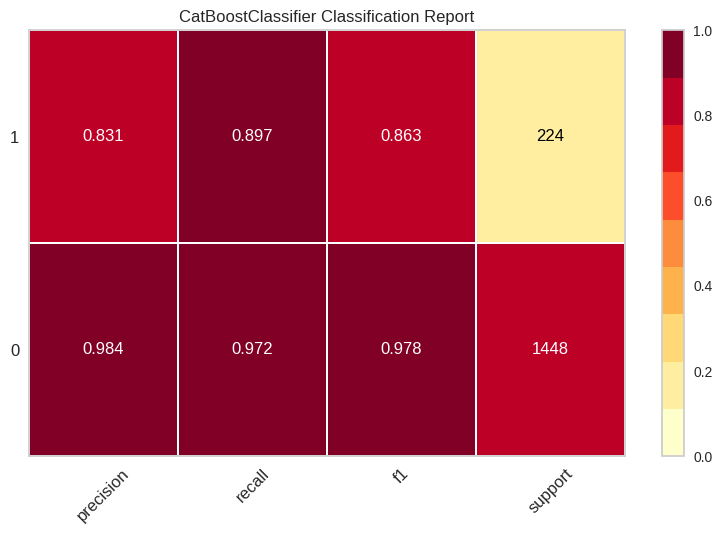

In [36]:
# Step 8 (Optional): Do we observe equal performance in each class?
clf.plot_model(best_model, plot='class_report')

In this section, you will apply transfer learning using zero-shot classification.

In [39]:
# Load the data again
spam_data = pd.read_csv(data_path / 'spam.csv')
spam_data

,label,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [ ]:
# Step 1: Do you need to do any text processing for transformer models?

In [40]:
# Step 2: Call the huggingface pipeline for zero-shot classification
# ## Make sure you load it into the GPU
from transformers import pipeline
spam_hf = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=0)

In [41]:
# Step 3: Initialize the list of candidate labels
candidate_labels = ['spam', 'not spam']

In [42]:
# Step 4: Test on one sample first
idx = 100
sms, label = spam_data.iloc[idx][['sms', 'label']]
print(f'{sms}: {label}')

results = spam_hf(sms, candidate_labels)
print(f"The top label is: {results['labels'][0]}")

Okay name ur price as long as its legal! Wen can I pick them up? Y u ave x ams xx: ham
The top label is: not spam


In [43]:
# Step 5: Apply to the rest of the dataset
# ## Remember to use swifter if you are doing pandas apply
spam_data['predicted_label'] = spam_data.sms.swifter.apply(lambda x: predict_label(x, spam_hf, candidate_labels))

Pandas Apply:   0%|          | 0/5572 [00:00<?, ?it/s]

In [45]:
spam_data['predicted_label'] = spam_data.predicted_label.apply(lambda x: 'ham' if x == 'not spam' else x)

In [44]:
# Step 6: How is the performance of the zero-shot classifier?
print(classification_report(spam_data['label'], spam_data['predicted_label']))

              precision    recall  f1-score   support

         ham       0.00      0.00      0.00      4825
    not spam       0.00      0.00      0.00         0
        spam       0.38      0.05      0.08       747

    accuracy                           0.01      5572
   macro avg       0.13      0.02      0.03      5572
weighted avg       0.05      0.01      0.01      5572



Before we think about finetuning it, go to https://huggingface.co/models and see if there are any existing pretrained models for sms spam.

In [46]:
# Step 7: Let's try another model
# ## Load the pipeline with the new model.
# ## Note that the pipeline name is changed to text-classification
# ## Check this page out for the various pipelines that hf has:
# ## https://huggingface.co/transformers/main_classes/pipelines.html#the-pipeline-abstraction

spam_hf = pipeline("text-classification", model="sureshs/distilbert-large-sms-spam", device=0)

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [47]:
# Step 8: Test on one sample first and check what is the output for this model,
# ## its not going to be the same as the zero-shot
idx = 100
sms, label = spam_data.iloc[idx][['sms', 'label']]
print(f'{sms}: {label}')

results = spam_hf(sms)

Okay name ur price as long as its legal! Wen can I pick them up? Y u ave x ams xx: ham


In [48]:
# Step 9: Create a function that can be applied to the pandas dataframe
# ## and returns ham and spam
def predict_spam(sms):
    results = spam_hf(sms)[0]
    if results['label'] == 'not spam':
        return 'ham'
    else:
        return 'spam'

In [49]:
# Step 9: Apply to the rest of the dataset
# ## Remember to use swifter if you are doing pandas apply
spam_data['predicted_label'] = spam_data.sms.swifter.apply(lambda x: predict_spam(x))

Pandas Apply:   0%|          | 0/5572 [00:00<?, ?it/s]

In [50]:
# Step 10: How is the performance of the zero-shot classifier?
print(classification_report(spam_data['label'], spam_data['predicted_label']))

              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      4825
        spam       1.00      0.99      0.99       747

    accuracy                           1.00      5572
   macro avg       1.00      0.99      1.00      5572
weighted avg       1.00      1.00      1.00      5572



### Assessment #2 What kind of face is that?!
Predict the emotions from facial images.

In [11]:
# The images are located in a folder called emotions_cv in our shared data folder
# Create a path to the image directory and we will use a directory loader from
# PyTorch to do the heavy lifting

# ## We will only use the training data for this assessment

image_dir = data_path / 'emotions_cv/train'

In this section, you will apply traditional ML methods.

In [12]:
# Step 0: Convert images into flattened grayscale data
import cv2
import os,glob
import numpy as np
from tqdm import tqdm
from os import listdir,makedirs
from os.path import isfile,join

labels = []
data = []
for cat in ('angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised'):
    src = data_path / f'emotions_cv/train/{cat}'
    files = list(filter(lambda f: isfile(join(src, f)), listdir(src)))

    for file in tqdm(files):
        img = cv2.imread((src / files[0]).as_posix())
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).reshape(48 * 48)
        labels.append(cat)
        data.append(gray)

labels = np.array(labels)
data = np.array(data)

100%|██████████| 3171/3171 [00:08<00:00, 357.35it/s]


In [19]:
# Step 1: Extract knowledge representation from images using unsupervised learning.
### Use 20 components

nmf = NMF(n_components=20)
nmf_features = nmf.fit_transform(data)

In [20]:
# Step 2: Combine the learned features with target label
facial_nmf = pd.DataFrame(nmf_features, index=labels)
facial_nmf['target'] = labels
facial_nmf

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,target
angry,0.214057,0.176826,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.050236,0.000000,1.082738,angry
angry,0.214057,0.176826,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.050236,0.000000,1.082738,angry
angry,0.214057,0.176826,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.050236,0.000000,1.082738,angry
angry,0.214057,0.176826,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.050236,0.000000,1.082738,angry
angry,0.169012,0.154530,0.000000,0.000000,0.055019,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.015066,1.078025,0.027890,angry
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
surprised,0.000000,0.000000,0.073167,0.044939,0.000000,0.045333,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.904601,surprised
surprised,0.000000,0.000000,0.073167,0.044939,0.000000,0.045333,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.904601,surprised
surprised,0.000000,0.000000,0.073167,0.044939,0.000000,0.045333,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.904601,surprised
surprised,0.000000,0.000000,0.073167,0.044939,0.000000,0.045333,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.904601,surprised


In [21]:
facial_nmf['target'].value_counts()

happy        7215
neutral      4965
sad          4830
fearful      4097
angry        3995
surprised    3171
disgusted     436
Name: target, dtype: int64

In [ ]:
# Step 3: Perform classification
from pycaret.classification import ClassificationExperiment

clf = ClassificationExperiment()
clf.setup(
    data=facial_nmf,
    target='target',
    train_size=0.7,
    preprocess=False,
    data_split_stratify=True,
    fix_imbalance=True
)

In [ ]:
# Step 4: Evaluate model performance
clf.compare_models(sort='AUC')

In [ ]:
# Step 5: Check performance on test data
predicted_results = clf.predict_model(best_model, raw_score=True)

In [ ]:
# Step 10: How is the performance for each category?
print(classification_report(predicted_results['target'], predicted_results['prediction_label']))

In this section, you will apply transfer learning.

In [ ]:
# Step 1: Prepare the dataset with a few standard transformations
# ## Assume that we are going to use a Resnet18 for this job.
transform = transforms.Compose(
    [transforms.Resize((299, 299)),
     transforms.ToTensor(),
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

dataset = datasets.ImageFolder(image_dir, transform=transform)

In [ ]:
# Step 2: Load the dataset into the CV datamodule
dataloader = ImageDataModule(dataset)

In [ ]:
from torchvision import models
# Step 3: Use a pretrained Resnet 18 model
image_model = models.resnet18(pretrained=True)

In [ ]:
# Step 4: Check if there are any layers that we need to change
# ## How many output nodes are there in the pretrained model's final layer?
# ## We have 7 classes of emotions.
image_model

In [ ]:
# Step 5: Change the necessary layers
image_model.fc = nn.Linear(512, 7, bias=True)

In [ ]:
# Step 6a (Optional): Do we want to freeze any layers?
# ## If so, run the following to get the layers' names
for name, params in image_model.named_parameters():
    print(name)

In [ ]:
# Step 6b (Optional): Choose a layer and freeze all the weights before it.
for name, params in image_model.named_parameters():
    if name == 'layer4.1.conv1.weight':
        break
    params.requires_grad = False

In [ ]:
# Step 7: Load it into Lightning Module
# ## Remember to specify model, loss, metric, and number of classes
model = ImageClassifier(
    model=image_model,
    loss=nn.CrossEntropyLoss(),
    metric=Accuracy(task='multiclass', num_classes=7),
    num_classes=7)

In [ ]:
# Step 8: Setup the trainer with 1 GPU and max number of epochs as 10
trainer = pl.Trainer(
    devices=1, # use one GPU, lightning automatically scales it to multi-GPUs
    accelerator='gpu',
    max_epochs=10, # set number of epochs
)

In [ ]:
# Step 9: Run tensorboard so that we can check our training as and when the
# ## results have been uploaded
%load_ext tensorboard
%tensorboard --logdir lightning_logs

In [ ]:
# Step 10: Train the model
trainer.fit(model, dataloader)